In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Se está trabajando en la rama testgh by @SOG


In [2]:
file_path = r"2002to2018.csv"  #2002to2016.csv
df = pd.read_csv(file_path)
df.head()
# df = df.sort_values(by='duration.s', ascending=False).reset_index(drop=True)
# formatT = '%Y-%m-%d %H:%M:%S'

df['Datetime'] = pd.to_datetime(df['start.date'] +
                                ' ' + 
                                df['start.time'])
df = df.set_index(pd.DatetimeIndex(df['Datetime']))
del df['flare']
del df['start.date']
del df['start.time']
del df['Datetime']

df.index

DatetimeIndex(['2002-02-12 21:29:56', '2002-02-12 21:44:08',
               '2002-02-13 00:53:24', '2002-02-13 04:22:52',
               '2002-02-13 07:03:52', '2002-02-13 07:07:48',
               '2002-02-13 07:20:56', '2002-02-13 08:53:20',
               '2002-02-13 10:02:56', '2002-02-13 12:29:32',
               ...
               '2018-02-08 17:00:04', '2018-02-08 18:42:44',
               '2018-02-08 19:52:56', '2018-02-09 14:53:32',
               '2018-02-09 15:45:28', '2018-02-09 16:41:28',
               '2018-02-09 18:15:56', '2018-02-10 13:04:36',
               '2018-02-26 15:49:56', '2018-03-03 04:04:08'],
              dtype='datetime64[ns]', name='Datetime', length=116143, freq=None)

In [3]:
## CALCULO DE ENERGIAS

Emax = []
Eprom = []
for i in df['energy.kev']:
    result = re.findall(r'[\d\.\d]+', i)
    Emax.append(float(result[1]))
    Eprom.append((float(result[0]) + float(result[1]))/2)

df['Emax.kev'] = Emax
df['Eprom.kev'] = Eprom
df.head()

,peak,end,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5,Emax.kev,Eprom.kev
Datetime,,,,,,,,,,,,,,,,,
2002-02-12 21:29:56,21:33:38,21:41:48,712,136,167304.0,12-25,592,-358,692,0,A1,P1,NaN,NaN,NaN,25.0,18.5
2002-02-12 21:44:08,21:45:06,21:48:56,288,7,9504.0,6-12,604,-341,694,9811,A1,P1,PE,Q1,NaN,12.0,9.0
2002-02-13 00:53:24,00:54:54,00:57:00,216,15,11448.0,6-12,-310,375,487,9825,A1,P1,NaN,NaN,NaN,12.0,9.0
2002-02-13 04:22:52,04:23:50,04:26:56,244,20,17400.0,12-25,-277,378,469,9822,A1,P1,NaN,NaN,NaN,25.0,18.5
2002-02-13 07:03:52,07:05:14,07:07:48,236,336,313392.0,25-50,-272,390,476,9825,A1,GS,P1,PE,Q2,50.0,37.5


### Datos nulos y filtrado

In [4]:
# print(df.isnull().sum())

# nan_df = df[df.isna().any(axis=1)] # Almacena DataFrame en donde encuentra datos nulos NaN
# print(nan_df.head())

dffull = df.dropna(how='any')
dffull # df sin datos nulos, la flag de calidad es Q1 y Q2

### Filtro 

# filtro = dffull['flag.4'] == 'Q1'
# filtro2 = dffull['flag.5'] == 'Q1'
# dfFiltro = dffull[filtro]
# dfFiltro2 = dffull[filtro2]

# dfn = pd.concat([dfFiltro,dfFiltro2], axis=1)

# dfn = dfn.sort_index()

###

dfn = pd.concat([dffull[dffull['flag.4'] == 'Q1']
                ,dffull[dffull['flag.5'] == 'Q1']
                ]).sort_index()

dfn # Contiene los que poseen Q1 en flag.4 o flag.5

dffull


# Solo hay datos nulos en las flags

,peak,end,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5,Emax.kev,Eprom.kev
Datetime,,,,,,,,,,,,,,,,,
2002-02-13 07:03:52,07:05:14,07:07:48,236,336,313392.0,25-50,-272,390,476,9825,A1,GS,P1,PE,Q2,50.0,37.5
2002-02-13 10:02:56,10:04:42,10:04:44,108,26,10368.0,6-12,-235,390,455,9822,A1,P1,PE,Q2,SE,12.0,9.0
2002-02-14 10:06:44,10:09:42,10:10:36,232,60,39168.0,6-12,-135,310,338,0,A1,GE,P1,PE,Q2,12.0,9.0
2002-02-18 20:18:40,20:53:30,21:12:48,3248,304,2736546.0,12-25,-272,-202,339,9830,a0,A1,P1,PE,Q1,25.0,18.5
2002-02-18 22:30:12,22:30:18,22:45:16,904,18,68890.0,6-12,-269,-235,357,9830,a0,A1,P1,PE,Q1,12.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-09 15:45:28,15:46:54,15:52:36,428,28,9088.0,6-12,0,0,0,2699,A0,DF,P1,PE,Q2,12.0,9.0
2018-02-09 16:41:28,16:42:54,16:43:32,124,18,2888.0,6-12,-345,-38,347,2699,A0,DF,P1,PE,Q2,12.0,9.0
2018-02-09 18:15:56,18:17:26,18:17:40,104,16,1656.0,6-12,-268,-38,271,2699,A0,DF,P1,PE,Q2,12.0,9.0


### Valores acotados

ok


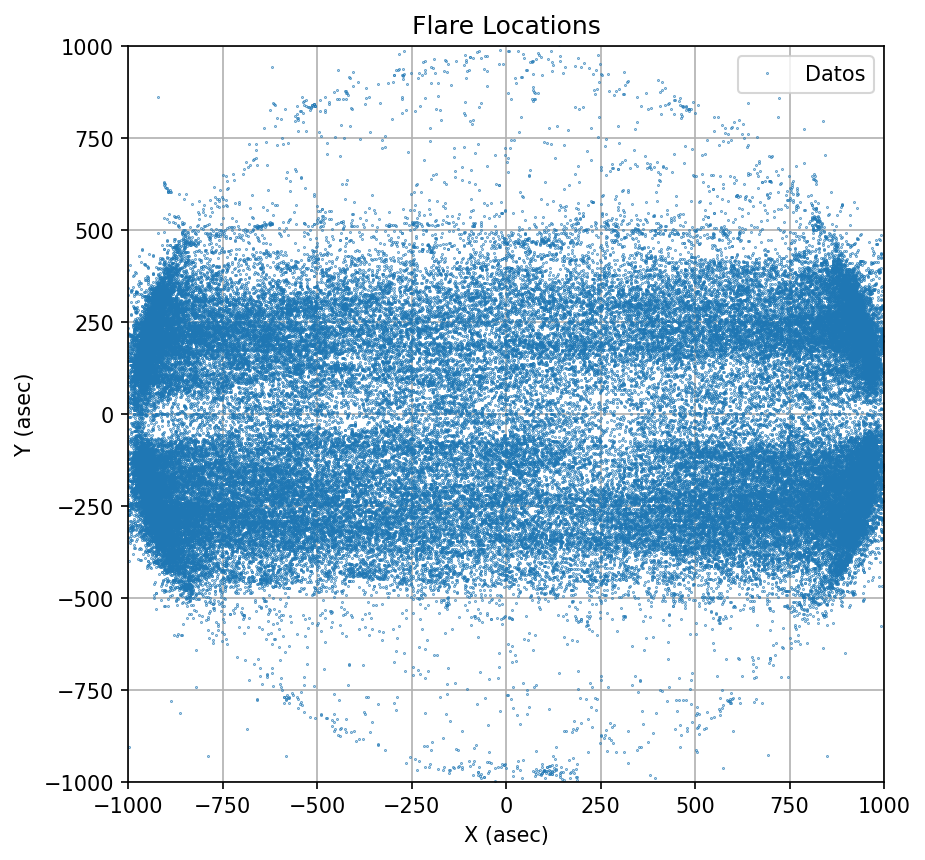

In [27]:
#### Se utilizan solo los valores referentes a la superficie solar y se descartan los puntos aislados
## To Do: Hacer una función que acote el dataframe

# dfacotada = df # Copia el dataframe que se desea acotar
# vmin = -1000
# vmax = 1000
# # Minimo

# test = dfacotada['x.pos.asec'].idxmin() # Guarda el index del valor minimo

# while (dfacotada['x.pos.asec'].min() <= vmin): # Esto se puede transformar en una función que acote los datos a un valor límite, como min() o max()
#     test = dfacotada['x.pos.asec'].idxmin()
#     dfacotada = dfacotada.drop([test], axis = 0)
    
# # Maximo

# test = dfacotada['x.pos.asec'].idxmax() # Guarda el index del valor maximo

# while (dfacotada['x.pos.asec'].max() >= vmax): 
#     test = dfacotada['x.pos.asec'].idxmax()
#     dfacotada = dfacotada.drop([test], axis = 0)

# print(dfacotada['x.pos.asec'].min())
# print(dfacotada['x.pos.asec'].max())

plt.figure(figsize=(6.5,6.5), dpi = 150)
plt.title('Flare Locations')
plt.plot(df['x.pos.asec'],
         df['y.pos.asec'], 'o', markersize=0.3, label='Datos')
plt.legend()
plt.xlabel('X (asec)')
plt.ylabel('Y (asec)')
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.grid()
print('ok')

# dffull no mod

ók


count    86959.000000
mean       -44.040030
std        445.609401
min     -10005.000000
25%       -253.000000
50%        -96.000000
75%        211.000000
max       1223.000000
Name: y.pos.asec, dtype: float64

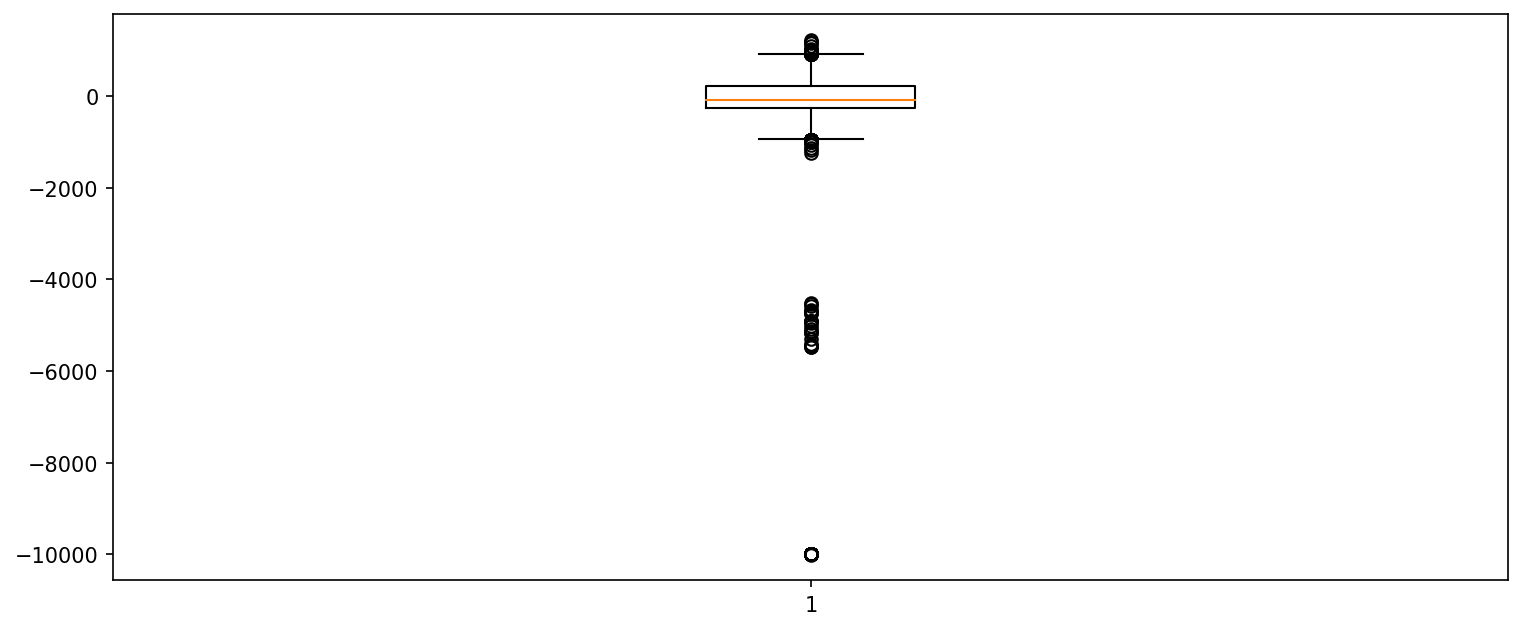

In [25]:
#### To Do: Estadística con los datos

energy = df['energy.kev'] == '6-12' # Se filtra por rango de energias
dfenergy = df[energy]

datos = dfenergy['y.pos.asec'] 
datos.describe()

plt.figure(figsize=(12,5), dpi = 150)
plt.boxplot(datos)


# plt.hist(datos, bins = 40, alpha = 0.7)
# plt.plot(dfenergy['x.pos.asec'], dfenergy['y.pos.asec'], 'o', markersize=0.3, label='Datos')
# plt.grid()

# plt.figure(figsize=(10,7), dpi = 150)
# sns.kdeplot(x=dfenergy['x.pos.asec'], y=dfenergy['y.pos.asec'])

# sns.pairplot(dfenergy[['x.pos.asec', 'y.pos.asec']], kind='kde')



print('ók')

dfenergy['y.pos.asec'].describe()

In [120]:
### ???

F1 = pd.DataFrame(df['flag.1'].value_counts(), columns=['flag.1'])
F2 = pd.DataFrame(df['flag.2'].value_counts(), columns=['flag.2'])
F3 = pd.DataFrame(df['flag.3'].value_counts(), columns=['flag.3'])
F4 = pd.DataFrame(df['flag.4'].value_counts(), columns=['flag.4'])
F5 = pd.DataFrame(df['flag.5'].value_counts(), columns=['flag.5'])

df['flag.5'].value_counts() 

Q2                34063
PE Q3             10258
P1 PE Q3           1383
PE Q2              1273
Q1                 1265
                  ...  
EE GS PS Q3           1
P1 Q5 SD SS           1
GE P1 PE Q4 SE        1
DR P1 Q3 SE           1
ES GE PS Q4           1
Name: flag.5, Length: 172, dtype: int64